# Whisky Recommender
<b>Tentative Workflow</b>
1. Extract Nose, Taste, Finish text
2. Combine text from Step into 1 column
3. Remove punctuations and stopwords from output of Step 2
4. Tokenize output of Step 3
5. Lemmatize output of Step 4
6. Create W2V vectors on output of Step 5
7. Create W2V vector for a test review
8. Print the title of the vector in Step 6 that is closest to the vector in Step 7

## Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('max_colwidth', 2000)

import string
import re
import nltk
from gensim.models import Word2Vec
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

## Load Data

In [2]:
data = pd.read_csv("TT_whisky_v2.csv")

# For Machine Learning, we would only need the Title and Combined Text columns
data = data[['BottleName', 'Nose', 'Taste', 'Finish']]

# This ensures that even if there are non-string values in the columns, they will be converted to strings before concatenation.
data['review'] = data['Nose'].astype(str) + " " + data['Taste'].astype(str) + " " + data['Finish'].astype(str)

# Check if the text gets combined correctly for each review
data.head(1)

,BottleName,Nose,Taste,Finish,review
0,"Cardinat 1995 27yr, 50%","Toffee, peanut brittle, musty wood, wood spice, vanilla, grape, golden caramel. Sweet toffee and fruits and a little nutty","Creamy caramel, smooth toasted oak, vanilla, grape, musty wood, sweet floral notes, gentle spice, slightly stale wood notes. Light, creamy and sweet. A nice balance of creamy caramel and fruits but the mouthfeel is a little too light and the wood is just a bit off.","Sweet caramel and cherry candy, vanilla, some gentle wood spice and slightly bitter wood notes creep in on the tail end","Toffee, peanut brittle, musty wood, wood spice, vanilla, grape, golden caramel. Sweet toffee and fruits and a little nutty Creamy caramel, smooth toasted oak, vanilla, grape, musty wood, sweet floral notes, gentle spice, slightly stale wood notes. Light, creamy and sweet. A nice balance of creamy caramel and fruits but the mouthfeel is a little too light and the wood is just a bit off. Sweet caramel and cherry candy, vanilla, some gentle wood spice and slightly bitter wood notes creep in on the tail end"


## Preprocess Data

### Remove Punctuations

In [3]:
# string.punctuation comprises of a list of all punctuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [4]:
def remove_punct(text):
    # store character only if it is not a punctuation
    text_nopunct = "".join([char for char in text if char not in string.punctuation])
    return text_nopunct

data['review_clean'] = data['review'].apply(lambda x: remove_punct(x))

#data.head()

### Tokenization

In [5]:
def tokenize(text):
    # Matches any character that is neither alphanumeric nor underscore
    # Add a + just in case there are 2 or more spaces between certain words
    tokens = re.split('\W+', text)
    return tokens

data['review_tokenized'] = data['review_clean'].apply(lambda x: tokenize(x.lower()))

#data.head()

### Remove Stopwords

In [6]:
import nltk

# NLTK(Natural Language Toolkit) in python has a list of stopwords stored in 16 different languages.
stopwords = nltk.corpus.stopwords.words('english')

# Add custom stopwords
custom_stopwords = ['nose', 'mouth', 'ive']

# Extend the existing list of stopwords with custom stopwords
stopwords.extend(custom_stopwords)


# if you get an error with the above code, comment the code above and run this & follow below directions:
# nltk.download()

<b>If you ran into issues with the above:</b>

1. Run <code>nltk.download()</code>. A new screen will pop up outside your Jupyter notebook. (It may be hidden behind other windows.)
2. Once this box opens up, click <code>all</code>, then <code>download</code>. Once this is done, restart your Jupyter notebook and try running the cell above again.

In [7]:
def remove_stopwords(tokenized_list):
    # Store in text only if word is not found in stopword i.e. it is not a stopword
    text = [word for word in tokenized_list if word not in stopwords]
    return text

data['review_nostop'] = data['review_tokenized'].apply(lambda x: remove_stopwords(x))

#data.head()

### Lemmatization

In [8]:
# if you get an error with this cell, uncomment the line of code and re-run this cell
#nltk.download('wordnet')

wn = nltk.WordNetLemmatizer()

def lemmatizing(tokenized_text):
    # return list of all lemmatized words for their corresponding words in tokenized_text
    text = [wn.lemmatize(word) for word in tokenized_text]
    return text

data['review_lemmatized'] = data['review_nostop'].apply(lambda x: lemmatizing(x))

data.head(3)

,BottleName,Nose,Taste,Finish,review,review_clean,review_tokenized,review_nostop,review_lemmatized
0,"Cardinat 1995 27yr, 50%","Toffee, peanut brittle, musty wood, wood spice, vanilla, grape, golden caramel. Sweet toffee and fruits and a little nutty","Creamy caramel, smooth toasted oak, vanilla, grape, musty wood, sweet floral notes, gentle spice, slightly stale wood notes. Light, creamy and sweet. A nice balance of creamy caramel and fruits but the mouthfeel is a little too light and the wood is just a bit off.","Sweet caramel and cherry candy, vanilla, some gentle wood spice and slightly bitter wood notes creep in on the tail end","Toffee, peanut brittle, musty wood, wood spice, vanilla, grape, golden caramel. Sweet toffee and fruits and a little nutty Creamy caramel, smooth toasted oak, vanilla, grape, musty wood, sweet floral notes, gentle spice, slightly stale wood notes. Light, creamy and sweet. A nice balance of creamy caramel and fruits but the mouthfeel is a little too light and the wood is just a bit off. Sweet caramel and cherry candy, vanilla, some gentle wood spice and slightly bitter wood notes creep in on the tail end",Toffee peanut brittle musty wood wood spice vanilla grape golden caramel Sweet toffee and fruits and a little nutty Creamy caramel smooth toasted oak vanilla grape musty wood sweet floral notes gentle spice slightly stale wood notes Light creamy and sweet A nice balance of creamy caramel and fruits but the mouthfeel is a little too light and the wood is just a bit off Sweet caramel and cherry candy vanilla some gentle wood spice and slightly bitter wood notes creep in on the tail end,"[toffee, peanut, brittle, musty, wood, wood, spice, vanilla, grape, golden, caramel, sweet, toffee, and, fruits, and, a, little, nutty, creamy, caramel, smooth, toasted, oak, vanilla, grape, musty, wood, sweet, floral, notes, gentle, spice, slightly, stale, wood, notes, light, creamy, and, sweet, a, nice, balance, of, creamy, caramel, and, fruits, but, the, mouthfeel, is, a, little, too, light, and, the, wood, is, just, a, bit, off, sweet, caramel, and, cherry, candy, vanilla, some, gentle, wood, spice, and, slightly, bitter, wood, notes, creep, in, on, the, tail, end]","[toffee, peanut, brittle, musty, wood, wood, spice, vanilla, grape, golden, caramel, sweet, toffee, fruits, little, nutty, creamy, caramel, smooth, toasted, oak, vanilla, grape, musty, wood, sweet, floral, notes, gentle, spice, slightly, stale, wood, notes, light, creamy, sweet, nice, balance, creamy, caramel, fruits, mouthfeel, little, light, wood, bit, sweet, caramel, cherry, candy, vanilla, gentle, wood, spice, slightly, bitter, wood, notes, creep, tail, end]","[toffee, peanut, brittle, musty, wood, wood, spice, vanilla, grape, golden, caramel, sweet, toffee, fruit, little, nutty, creamy, caramel, smooth, toasted, oak, vanilla, grape, musty, wood, sweet, floral, note, gentle, spice, slightly, stale, wood, note, light, creamy, sweet, nice, balance, creamy, caramel, fruit, mouthfeel, little, light, wood, bit, sweet, caramel, cherry, candy, vanilla, gentle, wood, spice, slightly, bitter, wood, note, creep, tail, end]"
1,"Cardinat 2003 19yr, 51.5%","Hot cinnamon cherry, brash toasted wood, caramel, big hot spice, tannic wood, some grape under all the spice.","Brash toasted wood, hot cinnamon and cherry, spice heat, light candy grape and caramel, bitter wood, almost nutty, floral notes. Nose doesn't lie this drinks hot and sweet. Feels unbalanced, not enough oak or fruits to overcome the heat","Toasted wood, caramel, hot spice, cinnamon, hot cherry. Some richer caramel wood notes on the finish save this a bit","Hot cinnamon cherry, brash toasted wood, caramel, big hot spice, tannic wood, some grape under all the spice. Brash toasted wood, hot cinnamon and cherry, spice heat, light candy grape and caramel, bitter wood, almost nutty, floral notes. Nose doesn't lie this drinks hot and sweet. Feels unbalanced, not enough oak or fruits to overcome the heat

In [9]:
food_choices = {
    "Hainanese Chicken Rice": "Hainanese chicken rice is a beloved dish consisting of tender poached chicken served with flavorful rice, accompanied by chili sauce and ginger paste. The chicken is typically succulent and infused with subtle aromas, while the rice is rich in flavor from being cooked in chicken broth.",
    "Laksa": "Laksa is a spicy noodle soup with a rich and creamy coconut curry broth. It's typically served with rice noodles and topped with shrimp, fish cakes, bean sprouts, and a hard-boiled egg. The broth is flavorful and aromatic, with a perfect balance of spice and creaminess.",
    "Char Kway Teow": "Char Kway Teow is a popular stir-fried noodle dish known for its smoky flavor and savory sauce. It features flat rice noodles cooked with Chinese sausage, shrimp, cockles, bean sprouts, and chives, all stir-fried in a flavorful dark soy sauce-based seasoning.",
    "Chilli Crab": "Chilli Crab is a quintessential Singaporean seafood dish featuring mud crab cooked in a tangy and spicy chili sauce. The sauce is rich and flavorful, with hints of sweetness from the tomato paste and a kick of heat from the chili. It's often enjoyed with mantou (fried buns) for dipping.",
    "Satay": "Satay is a popular street food in Singapore consisting of skewered and grilled meat served with a flavorful peanut sauce. The meat is marinated in a blend of spices, then grilled to perfection, resulting in tender and juicy skewers. It's often served with cucumber slices and rice cakes.",
    "Roti Prata": "Roti Prata is a crispy and flaky flatbread that originated from Indian cuisine but has become a favorite in Singapore. It's typically served with a side of savory curry dipping sauce, which complements the buttery and crispy texture of the prata.",
    "Nasi Lemak": "Nasi Lemak is a traditional Malay dish known for its fragrant coconut rice served with an array of flavorful accompaniments. It's often accompanied by fried chicken or fish, sambal chili for heat, fried anchovies and roasted peanuts for crunch, cucumber slices for freshness, and a hard-boiled egg for protein.",
    "Mee Goreng": "Mee Goreng is a flavorful and spicy stir-fried noodle dish with origins in Indian and Malay cuisine. It features yellow noodles stir-fried with a variety of vegetables, tofu, shrimp, and a spicy and tangy sauce made from a blend of chili, tomato, and spices.",
    "Hokkien Mee": "Hokkien Mee is a popular noodle dish in Singapore made from a mix of yellow and rice noodles stir-fried with seafood, such as shrimp and squid, and vegetables like cabbage and bean sprouts. The dish is infused with a rich seafood flavor from the broth, resulting in a hearty and satisfying meal.",
    "Mee Siam": "Mee Siam is a flavorful noodle dish with Malay and Thai influences, popular in Singapore. It features rice vermicelli noodles cooked in a spicy, sweet, and tangy gravy, served with prawns, tofu, hard-boiled egg, and bean sprouts. It's a vibrant and satisfying dish with a perfect balance of flavors.",
    "Kway Chap": "Kway Chap is a comforting noodle soup dish of Teochew origin popular in Singapore. It features wide rice noodles served in a rich and aromatic broth made from pork bones and various spices, accompanied by tender braised pork, tofu, hard-boiled eggs, and offal. It's a hearty and flavorful meal that's perfect for any time of the day.",
    "Tau Huay": "Tau Huay, also known as tofu pudding or douhua, is a comforting dessert popular in Singapore. It's made from soft and silky smooth tofu pudding served with a sweet syrup, often flavored with pandan leaves or ginger for added fragrance. It's a light and refreshing dessert perfect for a hot day.",
    "Chwee Kueh": "Chwee Kueh is a classic Teochew snack in Singapore made from steamed rice cakes topped with a savory mixture of preserved radish (chye poh) and fried shallots. It's typically served with a side of spicy chili sauce for added flavor and heat. The soft and slightly chewy texture of the rice cakes contrasts beautifully with the crunchy toppings.",
    "Putu Piring": "Putu Piring is a traditional Malay dessert in Singapore made from steamed rice flour cakes filled with gooey gula melaka (palm sugar) and served with freshly grated coconut. It's a sweet and fragrant treat with a melt-in-your-mouth texture, perfect for satisfying your sweet tooth.",
    "Ice Kachang": "Ice Kachang is a beloved dessert in Singapore made from shaved ice topped with colorful syrup, sweetened condensed milk, red beans, attap chee (palm seed), grass jelly, and corn. It's a refreshing and sweet treat that's perfect for cooling down on a hot day.",
    "Mee Rebus": "Mee Rebus is a popular Malay noodle dish in Singapore, featuring yellow noodles drenched in a thick and flavorful sweet potato-based gravy. The gravy is cooked with a blend of spices, dried shrimp, and peanuts, giving it a rich and savory taste. It's typically garnished with boiled egg, fried tofu, bean sprouts, and crispy shallots.",
    "Prawn Noodles": "Prawn Noodles, also known as 'Hae Mee' in Hokkien, is a flavorful noodle soup dish in Singapore made with a rich broth flavored with prawn heads and shells. The broth is simmered for hours to extract maximum flavor and then served with yellow noodles, prawns, slices of pork, hard-boiled egg, and bean sprouts. It's a comforting and hearty dish enjoyed by many.",
    "Kacang Pool": "Kacang Pool is a hearty and savory bean stew dish popular in Singapore's Arab community. It's made from mashed fava beans cooked with tomatoes, onions, garlic, and a blend of spices such as cumin and paprika. It's typically served with toasted bread or pita, making it a satisfying meal for breakfast or brunch.",
    "Nasi Goreng": "Nasi Goreng, which translates to 'fried rice' in Indonesian, is a flavorful fried rice dish popular in Singapore. It's cooked with a mix of spices, garlic, shallots, shrimp paste, and kecap manis (sweet soy sauce), giving it a rich and aromatic flavor. It's often served with fried eggs, sliced cucumbers, and krupuk (shrimp crackers) for added crunch.",
    "Lontong": "Lontong is a traditional Indonesian dish popular in Singapore, consisting of compressed rice cakes served with a coconut milk-based soup and a variety of side dishes such as tofu, hard-boiled eggs, vegetables, and sambal (spicy chili paste). The soup is flavored with spices such as lemongrass, galangal, and turmeric, giving it a fragrant and savory taste.",
    "Mee Soto": "Mee Soto is a comforting noodle soup dish popular in Singapore and Malaysia, made with yellow noodles served in a fragrant and flavorful chicken broth. The broth is cooked with spices such as lemongrass, galangal, and turmeric, giving it a rich and aromatic flavor. It's typically garnished with shredded chicken, bean sprouts, fried shallots, and fresh cilantro, making it a satisfying and hearty meal.",
    "Bubur Cha Cha": "Bubur Cha Cha is a traditional Nyonya dessert popular in Singapore, made from a coconut milk-based soup with sweet potatoes, yam, taro, and tapioca pearls. The soup is flavored with pandan leaves and palm sugar, giving it a fragrant and sweet taste. It's a comforting and delicious dessert enjoyed by many.",
    "Ondeh Ondeh": "Ondeh Ondeh is a popular Malay dessert in Singapore, consisting of glutinous rice balls filled with gula melaka (palm sugar) and coated in grated coconut. The rice balls are boiled until they float to the surface, indicating that they are cooked, and then rolled in grated coconut for added texture. They are sweet and chewy, with a burst of caramelized palm sugar in the center, making them a delightful treat.",
    "Nasi Kerabu": "Nasi Kerabu is a traditional Malay dish popular in Singapore, consisting of blue-colored rice served with an assortment of herbs, vegetables, and proteins. The rice gets its vibrant color from the petals of the butterfly pea flower, and it's typically served with items such as fried chicken, salted egg, fish crackers, and a variety of pickles. It's a flavorful and colorful dish that's as visually appealing as it is delicious.",
    "Ketupat": "Ketupat is a traditional Malay rice cake popular in Singapore, made from woven palm leaves filled with rice and then boiled until cooked. It's often served with dishes such as rendang or satay, and it's a symbol of celebration and festivity, commonly enjoyed during festive occasions such as Hari Raya Aidilfitri. The rice cakes have a firm texture and a subtle flavor, making them a perfect accompaniment to savory dishes.",
    "Kueh Dadar": "Kueh Dadar is a traditional Nyonya dessert popular in Singapore, made from pandan-flavored crepes filled with sweetened grated coconut. The crepes are cooked until they are slightly crispy on the edges and then rolled up with the coconut filling inside. They are fragrant and sweet, with a hint of pandan flavor, making them a delightful treat for any occasion."
}


In [10]:
# Create a DataFrame from the dictionary
menu = pd.DataFrame.from_dict(food_choices, orient='index', columns=['Description'])

# Reset index to have the food names as a column
menu.reset_index(inplace=True)
menu.columns = ['Food Name', 'Description']


## EDA

<Axes: title={'center': 'Top 20 Unigrams'}>

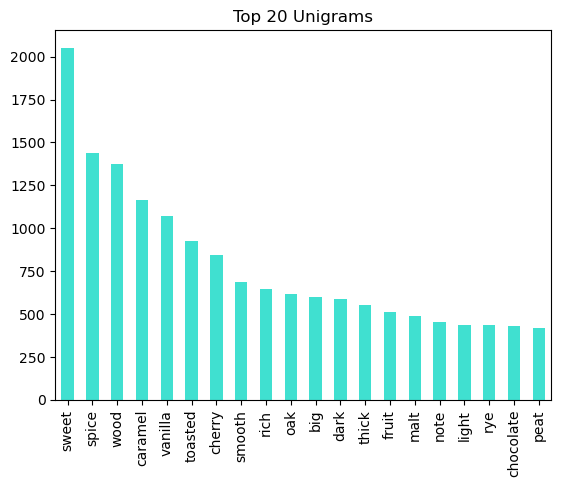

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of lemmatized tokens into strings for each row
texts = [' '.join(tokens) for tokens in data['review_lemmatized']]

# Initialize CountVectorizer with custom stopwords
cvec = CountVectorizer(stop_words=stopwords)

# Fit and transform the text data
vectorized_text = cvec.fit_transform(texts)

# Convert the vectorized text to a DataFrame
nf_reddit_df = pd.DataFrame(vectorized_text.toarray(), columns=cvec.get_feature_names_out())

# Sum the counts of each word and plot the top 20 unigrams
nf_reddit_df.sum().sort_values(ascending=False).head(20).plot(kind="bar", color='turquoise', title="Top 20 Unigrams")


<Axes: title={'center': 'Top 20 Bigrams'}>

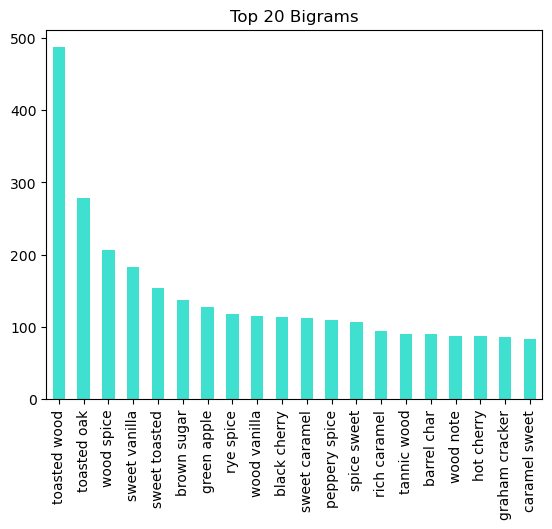

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert list of lemmatized tokens into strings for each row
texts = [' '.join(tokens) for tokens in data['review_lemmatized']]

# Initialize CountVectorizer with custom stopwords and bigram range
cvec = CountVectorizer(stop_words=stopwords, ngram_range=(2, 2))

# Fit and transform the text data
vectorized_text = cvec.fit_transform(texts)

# Convert the vectorized text to a DataFrame
nf_reddit_df = pd.DataFrame(vectorized_text.toarray(), columns=cvec.get_feature_names_out())

# Sum the counts of each bigram and plot the top 20 bigrams
nf_reddit_df.sum().sort_values(ascending=False).head(20).plot(kind="bar", color='turquoise', title="Top 20 Bigrams")


In [13]:
# Start with loading all necessary libraries
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [14]:
# Assuming data['review_lemmatized'] is a Pandas Series
text = ' '.join(data['review_lemmatized'].astype(str))
text1 = ' '.join(menu['Description'].astype(str))
# Generate word cloud
wordcloud = WordCloud().generate(text)
wordcloud1 = WordCloud().generate(text1)

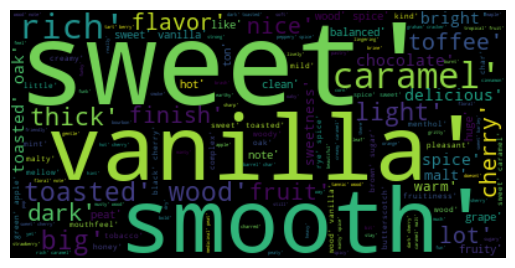

In [15]:
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

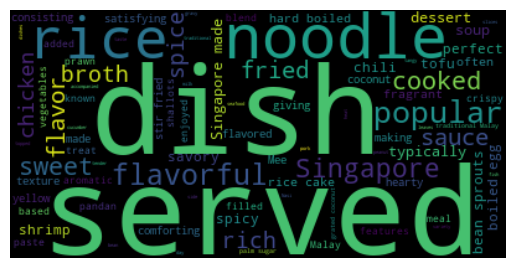

In [16]:
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis("off")
plt.show()

## Train Model

In [24]:
# Train the word2vec model
# vector_size = size of word vector. size input all dimensions that meet window param value
# window = number of words before and after the focus word that will be considered as context
# min_count = number of times word must appear in corpus in order to create a word vector
### Important - Model will only be trained on words that meet min_count so it may not learn all words as a result
from gensim.models import Word2Vec

# Tokenize the sentences in the "review" column
tokenized_reviews = data["review"].apply(lambda x: x.split())  # Assuming each review is a string of words separated by whitespace

# Train the Word2Vec model
w2v_model = Word2Vec(tokenized_reviews, vector_size=100, window=5, min_count=5)

# create a list to store the average of all word vectors for each row of data
review_vect_list = []

# Iterate through each row in data
for index, row in data.iterrows():
    # Create a Word2Vec vector for each row (review) in data
    # By applying the W2V model on each word of each review, we get the word vector (embedding) for each word
    # Each row (review) will be represented by the average of all vectors of all words in each row that model has trained on
    model_vector = (np.mean([w2v_model.wv.get_vector(token) for token in row['review_lemmatized'] if token in w2v_model.wv], axis=0)).tolist()

    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        review_vect_list.append(model_vector)
    else:
        review_vect_list.append([str(0) for i in range(100)])
        
word2vec_df = pd.DataFrame(review_vect_list)

# Add 'sentence_vector' column to data DataFrame
data['sentence_vector'] = word2vec_df.values.tolist()


In [25]:
# create a list to store the average of all word vectors for each row of data
review_vect_list = []

# Iterate through each row in X train data
for index, row in data.iterrows():

    # Create a Word2Vec vector for each row (review) in train data 
    # By applying the W2V model on each word of each review, we get the word vector (embedding) for each word
    # Each row (review) will be represented by average of all vectors of all words in each row that model has trained on
    model_vector = (np.mean([w2v_model.wv.get_vector(token) for token in row['review_lemmatized'] if token in w2v_model.wv], axis=0)).tolist()

    # Check if the line exists else it is vector of zeros
    if type(model_vector) is list:  
        review_vect_list.append(model_vector)
    else:
        review_vect_list.append([str(0) for i in range(100)])
        
word2vec_df = pd.DataFrame(review_vect_list)

In [26]:
# Add 'sentence_vector' column to data DataFrame
data['sentence_vector'] = word2vec_df.values.tolist()
#data.head()

## Make Predictions

In [27]:
# Function to get word vectors
def get_word_vectors(sentence):
    word_vectors = []
    for word in sentence.split():
        if word in w2v_model.wv:
            word_vectors.append(w2v_model.wv[word])
    return word_vectors

# Function to calculate sentence vector by averaging word vectors
def get_sentence_vector(sentence):
    word_vectors = get_word_vectors(sentence)
    if not word_vectors:
        return np.zeros(w2v_model.vector_size)
    return np.mean(word_vectors, axis=0)

# Function to find the closest sentence to the input text and calculate the cosine similarity percentage
def find_closest_sentence(input_text, data):
    input_vector = get_sentence_vector(input_text)
    max_similarity = -1
    closest_sentence = None
    closest_similarity_percent = 0
    
    for index, row in data.iterrows():
        sentence_vector = row['sentence_vector']
        similarity = cosine_similarity([input_vector], [sentence_vector])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_sentence = row['BottleName']
            closest_similarity_percent = similarity  # Save the similarity percentage

    return closest_sentence, closest_similarity_percent

    # Convert cosine similarity to percentage
    closest_similarity_percent = "{:.2f}".format(closest_similarity * 100)
    
    return closest_sentence, closest_similarity_percent


In [28]:
# Function to display food choices and get user input
def select_food_choices(num_choices=3):
    print("Select", num_choices, "food choices:")
    selected_foods = []
    for i in range(num_choices):
        print("Choice", i+1)
        for index, (food, description) in enumerate(food_choices.items(), start=1):
            print(f"{index}. {food} - {description}")

        # Get user choice
        choice_index = input("Enter the number of your choice: ")
        try:
            choice_index = int(choice_index)
            if 1 <= choice_index <= len(food_choices):
                selected_foods.append(list(food_choices.keys())[choice_index - 1])
            else:
                print("Invalid choice. Please enter a number between 1 and", len(food_choices))
                return select_food_choices(num_choices)  # Ask again for valid input
        except ValueError:
            print("Invalid input. Please enter a number.")
            return select_food_choices(num_choices)  # Ask again for valid input
    return selected_foods


In [29]:
### Welcome message and food choices
print("Welcome to the food recommender system!")
print("Select 5 food choices:")

# Display food choices
for i, food in enumerate(food_choices.keys(), start=1):
    print(f"{i}. {food} - {food_choices[food]}")

# Prompt user to choose 5 foods
selected_foods = []
while len(selected_foods) < 5:
    choice = input("\nEnter the number of your choice: ")
    if choice.isdigit():
        choice = int(choice)
        if 1 <= choice <= len(food_choices):
            food = list(food_choices.keys())[choice - 1]
            if food not in selected_foods:
                selected_foods.append(food)
            else:
                print("You have already selected this food. Please choose a different one.")
        else:
            print("Invalid choice. Please enter a number within the range.")
    else:
        print("Invalid input. Please enter a number.")

# Find the closest review for each selected food
closest_food = None
max_similarity_percent = -1
closest_reviews = []  # Initialize list to store closest reviews

for food in selected_foods:
    food_description = food_choices[food]
    closest_sentence, closest_similarity_percent = find_closest_sentence(food_description, data)
    #print("\nFor", food, ":")
    #print("Closest Review:", closest_sentence)
    #print("Cosine Similarity Percentage:", format(closest_similarity_percent, '.2%'))
    
    closest_reviews.append((food, closest_sentence, closest_similarity_percent))  # Store the closest review along with the food
    
    # Keep track of the food with the highest similarity percentage
    if closest_similarity_percent > max_similarity_percent:
        max_similarity_percent = closest_similarity_percent
        closest_food = food

# Sort the closest reviews based on similarity percentage in descending order
closest_reviews.sort(key=lambda x: x[2], reverse=True)

# Display the top 5 closest reviews
print("\nClosest reviews based on the selected foods:")
for i, (food, closest_sentence, closest_similarity_percent) in enumerate(closest_reviews[:5], start=1):
    print(f"Food Chosen: {food}")

# Combine descriptions of selected foods
combined_description = " ".join([food_choices[food] for food in selected_foods])

# Find closest reviews based on combined description
closest_reviews_combined = []

for index, row in data.iterrows():
    sentence_vector = row['sentence_vector']
    similarity = cosine_similarity([get_sentence_vector(combined_description)], [sentence_vector])[0][0]
    closest_reviews_combined.append((row['BottleName'], similarity))

# Sort the closest reviews based on similarity percentage in descending order
closest_reviews_combined.sort(key=lambda x: x[1], reverse=True)

# Display the top 5 closest reviews based on the combined description
print("\nTop 5 whisky recommendations based on the chosen foods:")
for i, (review, similarity) in enumerate(closest_reviews_combined[:5], start=1):
    print(f"{i}. Whisky: {review}, Cosine Similarity: {format(similarity, '.2%')}")

Welcome to the food recommender system!
Select 5 food choices:
1. Hainanese Chicken Rice - Hainanese chicken rice is a beloved dish consisting of tender poached chicken served with flavorful rice, accompanied by chili sauce and ginger paste. The chicken is typically succulent and infused with subtle aromas, while the rice is rich in flavor from being cooked in chicken broth.
2. Laksa - Laksa is a spicy noodle soup with a rich and creamy coconut curry broth. It's typically served with rice noodles and topped with shrimp, fish cakes, bean sprouts, and a hard-boiled egg. The broth is flavorful and aromatic, with a perfect balance of spice and creaminess.
3. Char Kway Teow - Char Kway Teow is a popular stir-fried noodle dish known for its smoky flavor and savory sauce. It features flat rice noodles cooked with Chinese sausage, shrimp, cockles, bean sprouts, and chives, all stir-fried in a flavorful dark soy sauce-based seasoning.
4. Chilli Crab - Chilli Crab is a quintessential Singaporean


Enter the number of your choice:  1

Enter the number of your choice:  2

Enter the number of your choice:  3

Enter the number of your choice:  4

Enter the number of your choice:  5



Closest reviews based on the selected foods:
Food Chosen: Laksa
Food Chosen: Char Kway Teow
Food Chosen: Hainanese Chicken Rice
Food Chosen: Chilli Crab
Food Chosen: Satay

Top 5 whisky recommendations based on the chosen foods:
1. Whisky: Kilchoman Sauternes, Cosine Similarity: 97.25%
2. Whisky: Balcones Texas Single Malt, Cosine Similarity: 96.97%
3. Whisky: Laphroaig 2000 22yr "Old Particular" K&L pick, refill hogshead 48.5%, Cosine Similarity: 96.67%
4. Whisky: Damoiseau Rhum Agricole, 55%, Cosine Similarity: 96.19%
5. Whisky: Staoisha 3yr(heavily peated Bunnahabhain), John Milroy K&L pick, Cosine Similarity: 96.15%


# Get description of selected foods and find closest sentence for each
for food in selected_foods:
    food_description = food_choices[food]
    closest_sentence, closest_similarity_percent = find_closest_sentence(food_description, data)
    print("\nFor", food, ":")
    print("Closest Review:", closest_sentence)
    print("Cosine Similarity Percentage:", format(closest_similarity_percent, '.2%'))

# Example usage:
print("Welcome to the food recommender system!")
selected_food = select_food_choice()
print("Selected food:", selected_food)

# Get description of selected food and find closest sentence
food_description = food_choices[selected_food]
closest_sentence, closest_similarity_percent = find_closest_sentence(food_description, data)
print("Closest Review:", closest_sentence)
print("Cosine Similarity Percentage:", closest_similarity_percent)

# Example usage:
print("Enter your preference")
input_text = input()

closest_sentence = find_closest_sentence(input_text, data)
print("Closest Review:", closest_sentence)